# Image segmentation with a U-Net-like architecture

## Download the data

In [1]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  unrar
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 113 kB of archives.
After this operation, 406 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 unrar amd64 1:5.6.6-2build1 [113 kB]
Fetched 113 kB in 1s (97.8 kB/s)
Selecting previously unselected package unrar.
(Reading database ... 113807 files and directories currently installed.)
Preparing to unpack .../unrar_1%3a5.6.6-2build1_amd64.deb ...
Unpacking unrar (1:5.6.6-2build1) ...
Setting up unrar (1:5.6.6-2build1) ...
update-alternatives: using /usr/bin/unrar-nonfree to provide /usr/bin/unrar (unrar) in auto mode
update-alternatives: warning: skip creation of /usr/share/man/man1/unrar.1.gz because associated file /usr/share/man/man1/unrar-nonfree.1.gz (of link group unrar) doesn't exist
Processing triggers f

In [2]:
!pip install gdown

In [3]:
!gdown --id 19CUrb1OtZQQGk3j5e5hEdMvRBnU3qfeW

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=19CUrb1OtZQQGk3j5e5hEdMvRBnU3qfeW
From (redirected): https://drive.google.com/uc?id=19CUrb1OtZQQGk3j5e5hEdMvRBnU3qfeW&confirm=t&uuid=0d46d855-48d9-4921-addd-6285f0c321fe
To: /kaggle/working/group3_cleaned.rar
100%|████████████████████████████████████████| 729M/729M [00:40<00:00, 18.0MB/s]


In [4]:
!gdown --id 11OWblBJz-2mSYCVupWgOyiO95xW6C7nJ

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11OWblBJz-2mSYCVupWgOyiO95xW6C7nJ
To: /kaggle/working/group3_train_kaggle_image_paths.csv
100%|████████████████████████████████████████| 371k/371k [00:00<00:00, 76.9MB/s]


In [ ]:
# !gdown --id 1JPOjKZITBvguI1gpYquqR7xX5q1_Y-DT

In [5]:
!unrar x /kaggle/working/group3_cleaned.rar


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /kaggle/working/group3_cleaned.rar

Creating    group3_cleaned                                            OK
Creating    group3_cleaned/01                                         OK
Extracting  group3_cleaned/01/01_postop_mri.mnc                            1  OK 
Extracting  group3_cleaned/01/01_preopmri-to-us_transform.xfm            1  OK 
Extracting  group3_cleaned/01/01_preop_mri.mnc                                 4  OK 
Extracting  group3_cleaned/01/01_tumor.mnc                               4  OK 
Creating    group3_cleaned/01/patient01_mask_slices                   OK
Extracting  group3_cleaned/01/patient01_mask_slices/coronal_63.png       4  OK 
Extracting  group3_cleaned/01/patient01_mask_slices/coronal_64.png       4  OK 
Extracting  group3_cleaned/01/patient01_mask_slices/coronal_65.png       4  OK 
Extracting  group3_cleaned/01/patient01_mask_slices/coronal_66.png       4  OK 
Extra

In [10]:
import os
import pathlib
import pandas as pd

## Prepare paths of input images and target segmentation masks

In [6]:
import re
pattern = r'\W(\d+)'
def extract_numbers(s):
    string = str(s)
    match = re.search(pattern,string)
    if match:
        return int(match.group(1))
    else:
        return -1

In [7]:
import re
pattern = r'(\d+).png'
def extract_numbers_files(s):
    string = str(s)
    match = re.search(pattern,string)
    if match:
        return int(match.group(1))
    else:
        return -1

In [8]:
import re
pattern_mask = r'(\d+)_mask.png'
def extract_numbers_mask(s):
    string = str(s)
    match = re.search(pattern_mask,string)
    if match:
        return int(match.group(1))
    else:
        return -1

In [11]:
folder_path = '/kaggle/working/group3_cleaned'

# Create a Path object for the folder
#folder = pathlib.Path(folder_path)

# Get a list of all the file paths in the folder and its subdirectories
sub_folders = [sub for f in pathlib.Path(folder_path).iterdir() if f.is_dir() for sub in pathlib.Path(f).iterdir() if sub.is_dir()]

In [12]:
sub_folders = sorted(sub_folders,key=extract_numbers)

In [13]:
sub_folders[:2]

[PosixPath('/kaggle/working/group3_cleaned/07/patient07_mask_slices'),
 PosixPath('/kaggle/working/group3_cleaned/07/patient07_pre_op_slices')]

In [14]:
coronal_original_image_lists = []
sagittal_original_image_lists = []
transversal_original_image_lists = []
coronal_mask_image_lists = []
sagittal_mask_image_lists = []
transversal_mask_image_lists = []
for sub_folder in sub_folders[:]:
    coronal_image_files = [str(f) for f in sub_folder.iterdir() if (f.is_file())
                           and ("mask" not in str(sub_folder)) and ("coronal" in str(f))]
    
    sagittal_image_files = [str(f) for f in sub_folder.iterdir() if (f.is_file()) and 
                            ("mask" not in str(sub_folder)) and ("sagittal" in str(f))]
    
    transversal_image_files = [str(f) for f in sub_folder.iterdir() if ((f.is_file()) and 
                               ("mask" not in str(sub_folder)) and ("transversal" in str(f)))]
    
    coronal_mask_image_files = [str(f) for f in sub_folder.iterdir() if (f.is_file()) and 
                                ("mask" in str(sub_folder)) and ("coronal" in str(f))]
    
    sagittal_mask_image_files = [str(f) for f in sub_folder.iterdir() if (f.is_file()) and
                                 ("mask" in str(sub_folder)) and ("sagittal" in str(f))]
    
    transversal_mask_image_files = [str(f) for f in sub_folder.iterdir() if (f.is_file()) and 
                                    ("mask" in str(sub_folder)) and ("transversal" in str(f))]
    
    coronal_original_image_lists.extend(sorted(coronal_image_files,key=extract_numbers))#sorted(image_files,key=extract_numbers))
    sagittal_original_image_lists.extend(sorted(sagittal_image_files,key=extract_numbers))
    transversal_original_image_lists.extend(sorted(transversal_image_files,key=extract_numbers))
    coronal_mask_image_lists.extend(sorted(coronal_mask_image_files,key=extract_numbers))#sorted(mask_image_files,key=extract_numbers_mask))
    sagittal_mask_image_lists.extend(sorted(sagittal_mask_image_files,key=extract_numbers))
    transversal_mask_image_lists.extend(sorted(transversal_mask_image_files,key=extract_numbers))

In [15]:
transversal_original_image_lists[:20]

['/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/transversal_161.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/transversal_162.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/transversal_163.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/transversal_164.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/transversal_165.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/transversal_166.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/transversal_167.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/transversal_168.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/transversal_169.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/transversal_170.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/transversal_171.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/transversal_172.png',
 '/kaggle/workin

In [16]:
len(coronal_original_image_lists)

487

In [17]:
coronal_original_image_lists[:20]

['/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_55.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_56.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_57.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_58.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_59.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_60.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_61.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_62.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_63.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_64.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_65.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_66.png',
 '/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_67.png',

In [18]:
len(transversal_original_image_lists)

945

In [19]:
df = pd.DataFrame([coronal_original_image_lists, sagittal_original_image_lists, transversal_original_image_lists,
                   coronal_mask_image_lists, sagittal_mask_image_lists,transversal_mask_image_lists]) #Each list would be added as a row
df = df.transpose() #To Transpose and make each rows as columns
df.columns=['coronal_original_image_lists', 'sagittal_original_image_lists', 'transversal_original_image_lists',
            'coronal_mask_image_lists', 'sagittal_mask_image_lists','transversal_mask_image_lists'] #Rename the columns

In [20]:
df.head()

,coronal_original_image_lists,sagittal_original_image_lists,transversal_original_image_lists,coronal_mask_image_lists,sagittal_mask_image_lists,transversal_mask_image_lists
0,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...
1,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...
2,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...
3,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...
4,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...


In [21]:
df.iloc[0,1]

'/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/sagittal_174.png'

In [22]:
df.iloc[0,4]

'/kaggle/working/group3_cleaned/07/patient07_mask_slices/sagittal_174.png'

In [23]:
df.to_csv("group3_train_kaggle_updated_image_paths.csv", index = False)

In [24]:
df_paths = pd.read_csv("/kaggle/working/group3_train_kaggle_image_paths.csv")

In [25]:
df_paths

,coronal_original_image_lists,sagittal_original_image_lists,transversal_original_image_lists,coronal_mask_image_lists,sagittal_mask_image_lists,transversal_original_image_lists.1
0,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_pr...
1,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_pr...
2,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_pr...
3,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_pr...
4,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_pr...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_ma...,/kaggle/working/group3_cleaned/07/patient07_pr...
...,...,...,...,...,...,...
1018,NaN,/kaggle/working/group3_cleaned/01/patient01_pr...,NaN,NaN,/kaggle/working/group3_cleaned/01/patient01_ma...,NaN
1019,NaN,/kaggle/working/group3_cleaned/01/patient01_pr...,NaN,NaN,/kaggle/working/group3_cleaned/01/patient01_ma...,NaN
1020,NaN,/kaggle/working/group3_cleaned/01/patient01_pr...,NaN,NaN,/kaggle/working/group3_cleaned/01/patient01_ma...,NaN
1021,NaN,/kaggle/working/group3_cleaned/01/patient01_pr...,NaN,NaN,/kaggle/working/group3_cleaned/01/patient01_ma...,NaN


In [26]:
original_images = list(df_paths['coronal_original_image_lists'].dropna())

In [27]:
len(original_images)

487

In [28]:
mask_images = list(df_paths['coronal_mask_image_lists'].dropna())

In [29]:
len(mask_images)

487

In [30]:
print("Number of samples:", len(original_images) + len(mask_images))

for input_path, target_path in zip(original_images[:10], mask_images[:10]):
    print(input_path, "|", target_path)

Number of samples: 974
/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_55.png | /kaggle/working/group3_cleaned/07/patient07_mask_slices/coronal_55.png
/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_56.png | /kaggle/working/group3_cleaned/07/patient07_mask_slices/coronal_56.png
/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_57.png | /kaggle/working/group3_cleaned/07/patient07_mask_slices/coronal_57.png
/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_58.png | /kaggle/working/group3_cleaned/07/patient07_mask_slices/coronal_58.png
/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_59.png | /kaggle/working/group3_cleaned/07/patient07_mask_slices/coronal_59.png
/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_60.png | /kaggle/working/group3_cleaned/07/patient07_mask_slices/coronal_60.png
/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_61.png | /kaggle/working/group3_cle

## What does one input image and corresponding segmentation mask look like?

In [ ]:
# from IPython.display import Image, display
# from keras.utils import load_img
# from PIL import ImageOps

# # Display input image #7
# display(Image(filename=original_images[1]))

# # Display auto-contrast version of corresponding target (per-pixel categories)
# img = ImageOps.autocontrast(load_img(mask_images[1]))
# display(img)

# Pytorch Implimentation

In [31]:
import torch
import torch.nn as nn
import torch.functional as f
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.transforms as tr
from torchmetrics import JaccardIndex
from torchinfo import summary

import numpy as np
import argparse
import re
import os
import scipy.io as sio
from tqdm import tqdm

# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from PIL import Image

In [32]:
class UNet(nn.Module):
    def __init__(self, num_channels=1, num_classes=1):
        super(UNet, self).__init__()
        num_feat = [64, 128, 256, 512, 1024]

        self.down1 = nn.Sequential(Conv3x3(num_channels, num_feat[0]))

        self.down2 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3(num_feat[0], num_feat[1]))

        self.down3 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3(num_feat[1], num_feat[2]))

        self.down4 = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                   Conv3x3(num_feat[2], num_feat[3]))

        self.bottom = nn.Sequential(nn.MaxPool2d(kernel_size=2),
                                    Conv3x3(num_feat[3], num_feat[4]))

        self.up1 = UpConcat(num_feat[4], num_feat[3])
        self.upconv1 = Conv3x3(num_feat[4], num_feat[3])

        self.up2 = UpConcat(num_feat[3], num_feat[2])
        self.upconv2 = Conv3x3(num_feat[3], num_feat[2])

        self.up3 = UpConcat(num_feat[2], num_feat[1])
        self.upconv3 = Conv3x3(num_feat[2], num_feat[1])

        self.up4 = UpConcat(num_feat[1], num_feat[0])
        self.upconv4 = Conv3x3(num_feat[1], num_feat[0])

        self.final = nn.Sequential(nn.Conv2d(num_feat[0],
                                             num_classes,
                                             kernel_size=1))#,
                                   # nn.Sigmoid())

    def forward(self, inputs, return_features=False):
        # print(inputs.data.size())
        down1_feat = self.down1(inputs)
        # print(down1_feat.size())
        down2_feat = self.down2(down1_feat)
        # # print(down2_feat.size())
        down3_feat = self.down3(down2_feat)
        # # print(down3_feat.size())
        # down4_feat = self.down4(down3_feat)
        # print(down4_feat.size())
        # bottom_feat = self.bottom(down2_feat)

        # print("bottom_feat.size(): ",bottom_feat.size())
        # up1_feat = self.up1(down3_feat, down2_feat)
        # # print("up1_feat.size(): ",up1_feat.size())
        # up1_feat = self.upconv1(up1_feat)
        # # print("up1_feat.size(): ",up1_feat.size())
        # up2_feat = self.up2(up1_feat, down1_feat)
        # # print("up2_feat.size(): ",up2_feat.size())
        # up2_feat = self.upconv2(up2_feat)
        # print("up2_feat.size(): ",up2_feat.size())
        up3_feat = self.up3(down3_feat, down2_feat)
        # # print(up3_feat.size())
        up3_feat = self.upconv3(up3_feat)
        # # print(up3_feat.size())
        up4_feat = self.up4(up3_feat, down1_feat)
        # # print(up4_feat.size())
        up4_feat = self.upconv4(up4_feat)
        # print(up4_feat.size())
        # Set a threshold (usually between 0.5 and 0.9)
        # threshold = 0.1
        if return_features:
            outputs = up4_feat
        else:
            outputs = self.final(up4_feat)

        # Apply thresholding
        # binary_predictions = (outputs > threshold).float().cuda()
        return outputs


In [33]:
class Conv3x3(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(Conv3x3, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(in_feat, out_feat,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1),
                                   nn.BatchNorm2d(out_feat),
                                   nn.ReLU())

        self.conv2 = nn.Sequential(nn.Conv2d(out_feat, out_feat,
                                             kernel_size=3,
                                             stride=1,
                                             padding=1),
                                   nn.BatchNorm2d(out_feat),
                                   nn.ReLU())

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.conv2(outputs)
        return outputs

In [34]:
class UpConcat(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(UpConcat, self).__init__()

        # self.up = nn.functional.interpolate(scale_factor=2)
        # self.deconv = nn.ConvTranspose2d(in_feat, out_feat,
        #                                  kernel_size=3,
        #                                  stride=1,
        #                                  dilation=1)

        self.deconv = nn.ConvTranspose2d(in_feat,
                                         out_feat,
                                         kernel_size=2,
                                         stride=2)

    def forward(self, inputs, down_outputs):
        # TODO: Upsampling required after deconv?
        # down_outputs_outputs = self.up(down_outputs)
        outputs = self.deconv(inputs)
#         # Debugging step: Print their shapes
#         print("down_outputs shape:", down_outputs.shape)
#         print("outputs shape:", outputs.shape)
        out = torch.cat([outputs, down_outputs[:, :, :outputs.size(2), :outputs.size(3)]], 1)
        return out

In [35]:
# class UpSample(nn.Module):
#     def __init__(self, in_feat, out_feat):
#         super(UpSample, self).__init__()

#         self.up = nn.Upsample(scale_factor=2, mode='nearest')

#         self.deconv = nn.ConvTranspose2d(in_feat,
#                                          out_feat,
#                                          kernel_size=2,
#                                          stride=2)

#     def forward(self, inputs, down_outputs):
#         # TODO: Upsampling required after deconv?
#         outputs = self.up(inputs)
#         # outputs = self.deconv(inputs)
#         out = torch.cat([outputs, down_outputs], 1)
#         return out

In [36]:
# def getMaskFileName(file):

#     mask_file = file.replace("flair.png", "seg.png")
#     mask_file = mask_file.replace("t1.png", "seg.png")
#     mask_file = mask_file.replace("t2.png", "seg.png")
#     mask_file = mask_file.replace("t1ce.png", "seg.png")

#     return mask_file


# def getImg(imgpathway):
#     # image_file = Image.open(imgpathway)  # open colour image
#     # img = image_file.convert('L')
#     # IMG = np.asarray(img.getdata())
#     # img = io.imread(imgpathway, as_grey=True)
#     img = Image.open(imgpathway)
#     # img = np.asarray(img)
#     # img *= 65536.0 / np.max(img)
#     # IMG.astype(np.uint16)
#     # plt.imshow(IMG, cmap='gray')
#     # plt.show()
#     return img


# def File2Image(self, index):
#     file = self.__file[index]
#     filename_fragments = file.split("_")
#     if filename_fragments[1] == '0' or filename_fragments[1] == '154':
#         # Not sure what to do here
#         return 0, 0

#     filename1 = filename_fragments[0] + filename_fragments[1] + '_' + \
#         str(int(filename_fragments[2]) - 1) + '_' + filename_fragments[3]
#     filename3 = filename_fragments[0] + filename_fragments[1] + '_' + \
#         str(int(filename_fragments[2]) + 1) + '_' + filename_fragments[3]

#     idx1 = self.__file.index(filename1)
#     idx3 = self.__file.index(filename3)
#     img1 = self.__im[idx1]
#     img3 = self.__im[idx3]

#     return img1, img3

In [37]:
for input_path, target_path in zip(original_images[:10], mask_images[:10]):
    print(input_path, "|", target_path)

/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_55.png | /kaggle/working/group3_cleaned/07/patient07_mask_slices/coronal_55.png
/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_56.png | /kaggle/working/group3_cleaned/07/patient07_mask_slices/coronal_56.png
/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_57.png | /kaggle/working/group3_cleaned/07/patient07_mask_slices/coronal_57.png
/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_58.png | /kaggle/working/group3_cleaned/07/patient07_mask_slices/coronal_58.png
/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_59.png | /kaggle/working/group3_cleaned/07/patient07_mask_slices/coronal_59.png
/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_60.png | /kaggle/working/group3_cleaned/07/patient07_mask_slices/coronal_60.png
/kaggle/working/group3_cleaned/07/patient07_pre_op_slices/coronal_61.png | /kaggle/working/group3_cleaned/07/patient07_mask_

In [38]:
class BraTSDatasetUnet(Dataset):
    __file = []
    __im = []
    __mask = []
    im_ht = 0
    im_wd = 0
    dataset_size = 0

    def __init__(self, original_images,mask_images, train=True, im_size=[512, 512], transform=None,binarize=None):

#         self.__file = []
        self.__im = []
        self.__mask = []
        self.im_ht = im_size[0]
        self.im_wd = im_size[1]
        self.transform = transform
        self.binarize = binarize

#         folder = dataset_folder
#         # # Open and load text file including the whole training data
#         if train:
#             folder = dataset_folder + "Train/"
#         else:
#             folder = dataset_folder + "Test/"

#         for file in os.listdir(folder):
#             if file.endswith(".png"):
#                 filename = os.path.splitext(file)[0]
#                 filename_fragments = filename.split("_")
#                 samekeywords = list(set(filename_fragments) & set(keywords))
#                 if len(samekeywords) == len(keywords):
#                     # 1. read file name
#                     self.__file.append(filename)
#                     # 2. read raw image
#                     # TODO: I think we should open image only in getitem,
#                     # otherwise memory explodes

#                     # rawImage = getImg(folder + file)
#                     self.__im.append(folder + file)
#                     # 3. read mask image
#                     mask_file = getMaskFileName(file)
#                     # maskImage = getImg(folder + mask_file)
#                     self.__mask.append(folder + mask_file)
        for input_path, target_path in zip(original_images, mask_images):
            self.__im.append(input_path)
            self.__mask.append(target_path)
        # self.dataset_size = len(self.__file)

        # print("lengths : ", len(self.__im), len(self.__mask))
        self.dataset_size = len(original_images) + len(mask_images)

#         if not train:
#             sio.savemat('filelist2.mat', {'data': self.__im})

    def __getitem__(self, index):

        img = Image.open(self.__im[index])
        mask = Image.open(self.__mask[index])

        img = img.resize((self.im_ht, self.im_wd))
        mask = mask.resize((self.im_ht, self.im_wd))
        # mask.show()

        if self.transform is not None:
            # TODO: Not sure why not take full image
            img_tr = self.transform(img)
            mask_tr = self.transform(mask)
        bi_mask_tr = self.binarize(mask_tr)
            # img_tr = self.transform(img[None, :, :])
            # mask_tr = self.transform(mask[None, :, :])

        return img_tr, bi_mask_tr
        # return img.float(), mask.float()

    def __len__(self):

        return len(self.__im)

In [39]:
class DICELossMultiClass(nn.Module):

    def __init__(self):
        super(DICELossMultiClass, self).__init__()

    def forward(self, output, mask):
        num_classes = output.size(1)
        dice_eso = 0
        for i in range(num_classes):
            probs = torch.squeeze(output[:, i, :, :], 1)
            mask = torch.squeeze(mask[:, i, :, :], 1)

            num = probs * mask
            num = torch.sum(num, 2)
            num = torch.sum(num, 1)

            # print( num )

            den1 = probs * probs
            # print(den1.size())
            den1 = torch.sum(den1, 2)
            den1 = torch.sum(den1, 1)

            # print(den1.size())

            den2 = mask * mask
            # print(den2.size())
            den2 = torch.sum(den2, 2)
            den2 = torch.sum(den2, 1)

            # print(den2.size())
            eps = 0.0000001
            dice = 2 * ((num + eps) / (den1 + den2 + eps))
            # dice_eso = dice[:, 1:]
            dice_eso += dice

        loss = 1 - torch.sum(dice_eso) / dice_eso.size(0)
        return loss


class DICELoss(nn.Module):

    def __init__(self):
        super(DICELoss, self).__init__()

    def forward(self, output, mask):

        probs = torch.squeeze(output, 1)
        mask = torch.squeeze(mask, 1)

        intersection = probs * mask
        intersection = torch.sum(intersection, 2)
        intersection = torch.sum(intersection, 1)

        den1 = probs * probs
        den1 = torch.sum(den1, 2)
        den1 = torch.sum(den1, 1)

        den2 = mask * mask
        den2 = torch.sum(den2, 2)
        den2 = torch.sum(den2, 1)

        eps = 1e-8
        dice = 2 * ((intersection + eps) / (den1 + den2 + eps))
        # dice_eso = dice[:, 1:]
        dice_eso = dice

        loss = 1 - torch.sum(dice_eso) / dice_eso.size(0)
        return loss

In [40]:
# # %% import transforms
# # %% Training settings
# parser = argparse.ArgumentParser(
#     description='UNet + BDCLSTM for BraTS Dataset')
# parser.add_argument('--batch-size', type=int, default=4, metavar='N',
#                     help='input batch size for training (default: 64)')
# parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
#                     help='input batch size for testing (default: 1000)')
# parser.add_argument('--train', action='store_true', default=False,
#                     help='Argument to train model (default: False)')
# parser.add_argument('--epochs', type=int, default=1, metavar='N',
#                     help='number of epochs to train (default: 10)')
# parser.add_argument('--lr', type=float, default=0.001, metavar='LR',
#                     help='learning rate (default: 0.01)')
# parser.add_argument('--cuda', action='store_true', default=False,
#                     help='enables CUDA training (default: False)')
# parser.add_argument('--log-interval', type=int, default=1, metavar='N',
#                     help='batches to wait before logging training status')
# parser.add_argument('--size', type=int, default=128, metavar='N',
#                     help='imsize')
# parser.add_argument('--load', type=str, default=None, metavar='str',
#                     help='weight file to load (default: None)')
# parser.add_argument('--data-folder', type=str, default='./Data/', metavar='str',
#                     help='folder that contains data (default: test dataset)')
# parser.add_argument('--save', type=str, default='OutMasks', metavar='str',
#                     help='Identifier to save npy arrays with')
# parser.add_argument('--modality', type=str, default='flair', metavar='str',
#                     help='Modality to use for training (default: flair)')
# parser.add_argument('--optimizer', type=str, default='SGD', metavar='str',
#                     help='Optimizer (default: SGD)')

# args = parser.parse_args()
# args.cuda = args.cuda and torch.cuda.is_available()

# DATA_FOLDER = args.data_folder

In [43]:
# Define your custom binarization function
def binarize(tensor, threshold):
    tensor = tensor.clone()
    tensor[tensor >= threshold] = 1
    tensor[tensor < threshold] = 0
    return tensor

In [44]:
# %% Loading in the Dataset
dset_train = BraTSDatasetUnet(original_images,mask_images, train=True,
                              transform=tr.Compose([
                                        tr.ToTensor(),
                                        tr.Grayscale(num_output_channels=1),  # Convert to single-channel grayscale
                                        tr.Normalize(mean=[0.5], std=[0.5]),
                                        tr.Lambda(lambda x: (x + 1) / 2),  # Rescale to [0, 1] 
                               ]),
                            binarize=tr.Lambda(lambda tensor: binarize(tensor, threshold=0.1))  # digitize
                            )

train_loader = DataLoader(dset_train,
                          batch_size=8,
                          shuffle=True, num_workers=0)

In [45]:
dset_test = BraTSDatasetUnet(original_images,mask_images, train=False,
                              transform=tr.Compose([
                                        tr.ToTensor(),
                                        tr.Grayscale(num_output_channels=1),  # Convert to single-channel grayscale
                                        tr.Normalize(mean=[0.5], std=[0.5]),
                                        tr.Lambda(lambda x: (x + 1) / 2),  # Rescale to [0, 1]                                       
                              ]),
                            binarize=tr.Lambda(lambda tensor: binarize(tensor, threshold=0.1))  # digitize
                            )

test_loader = DataLoader(dset_test,
                         batch_size=8,
                         shuffle=False, num_workers=0)

In [46]:
batch_inputs, batch_labels = next(iter(test_loader))
print(f"Input shape: {batch_inputs.shape}, Label shape: {batch_labels.shape}")

Input shape: torch.Size([8, 1, 512, 512]), Label shape: torch.Size([8, 1, 512, 512])


In [47]:
batch_inputs[0].unique()

tensor([0.0000, 0.0039, 0.0078, 0.0118, 0.0157, 0.0196, 0.0235, 0.0275, 0.0314,
        0.0353, 0.0392, 0.0431, 0.0471, 0.0510, 0.0549, 0.0588, 0.0627, 0.0667,
        0.0706, 0.0745, 0.0784, 0.0824, 0.0863, 0.0902, 0.0941, 0.0980, 0.1020,
        0.1059, 0.1098, 0.1137, 0.1176, 0.1216, 0.1255, 0.1294, 0.1333, 0.1373,
        0.1412, 0.1451, 0.1490, 0.1529, 0.1569, 0.1608, 0.1647, 0.1686, 0.1725,
        0.1765, 0.1804, 0.1843, 0.1882, 0.1922, 0.1961, 0.2000, 0.2039, 0.2078,
        0.2118, 0.2157, 0.2196, 0.2235, 0.2275, 0.2314, 0.2353, 0.2392, 0.2431,
        0.2471, 0.2510, 0.2549, 0.2588, 0.2627, 0.2667, 0.2706, 0.2745, 0.2784,
        0.2824, 0.2863, 0.2902, 0.2941, 0.2980, 0.3020, 0.3059, 0.3098, 0.3137,
        0.3176, 0.3216, 0.3255, 0.3294, 0.3333, 0.3373, 0.3412, 0.3451, 0.3490,
        0.3529, 0.3569, 0.3608, 0.3647, 0.3686, 0.3725, 0.3765, 0.3804, 0.3843,
        0.3882, 0.3922, 0.3961, 0.4000, 0.4039, 0.4078, 0.4118, 0.4157, 0.4196,
        0.4235, 0.4275, 0.4314, 0.4353, 

In [48]:
batch_labels[1].unique(),batch_labels[0].unique()

(tensor([0., 1.]), tensor([0., 1.]))

In [49]:
bce_loss = nn.BCELoss()
# output = bce_loss(input_tens, target_tens)
# print("Binary Cross Entropy Loss:", output.item())

# Example 2D tensor
input_tens_2d = torch.tensor([[0.4576, 0.6496, 0.6783],
                              [0.4895, 0.9454, 0.5443],
                              [0.9491, 0.3825, 0.7235]], requires_grad=True)
target_tens_2d = torch.tensor([[0.2432, 0.1579, 0.0325],
                               [0.3464, 0.2442, 0.3847],
                               [0.4528, 0.0876, 0.0499]])

output_2d = bce_loss(input_tens_2d, target_tens_2d)
print("Binary Cross Entropy Loss (2D):", output_2d.item())

Binary Cross Entropy Loss (2D): 1.0827546119689941


In [50]:
output_2d = bce_loss(batch_inputs[0],batch_labels[0])
output_2d

tensor(0.3289)

In [51]:
print("Training Data : ", len(train_loader.dataset))
print("Test Data :", len(test_loader.dataset))

Training Data :  487
Test Data : 487


In [52]:
device = torch.device("cuda")
# model = model_name.from_pretrained("./my_module")  # load my saved model
# tokenizer = tokenizer_name.from_pretrained("./my_module")  # load tokenizer
# Create the model
model = UNet(num_channels=1, num_classes=1)  # Assuming 3 input channels and 2 output classes
model.to(device)

UNet(
  (down1): Sequential(
    (0): Conv3x3(
      (conv1): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (down2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv3x3(
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128

In [53]:
summary(model, input_size=(8, 1, 180, 180))

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [8, 1, 180, 180]          29,178,112
├─Sequential: 1-1                        [8, 64, 180, 180]         --
│    └─Conv3x3: 2-1                      [8, 64, 180, 180]         --
│    │    └─Sequential: 3-1              [8, 64, 180, 180]         768
│    │    └─Sequential: 3-2              [8, 64, 180, 180]         37,056
├─Sequential: 1-2                        [8, 128, 90, 90]          --
│    └─MaxPool2d: 2-2                    [8, 64, 90, 90]           --
│    └─Conv3x3: 2-3                      [8, 128, 90, 90]          --
│    │    └─Sequential: 3-3              [8, 128, 90, 90]          74,112
│    │    └─Sequential: 3-4              [8, 128, 90, 90]          147,840
├─Sequential: 1-3                        [8, 256, 45, 45]          --
│    └─MaxPool2d: 2-4                    [8, 128, 45, 45]          --
│    └─Conv3x3: 2-5                      [8, 256, 45, 45]      

In [54]:

optimizer = optim.Adam(model.parameters(), lr=0.001)#,betas=(args.beta1, args.beta2))
# Defining Loss Function
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.L1Loss()

In [55]:
def train(epoch, loss_lsit):
    model.train()
    for batch_idx, (image, mask) in enumerate(train_loader):
#         print("batch: ",batch_idx)
        if torch.cuda.is_available():
            image, mask = image.cuda(), mask.cuda()

#         image, mask = Variable(image), Variable(mask)

        optimizer.zero_grad()
#         print(image.min())
        output = model(image)
#         print(output.min())
        loss = criterion(output, mask)
        loss_list.append(loss.item())

        loss.backward()
        optimizer.step()

        if batch_idx % 1 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t BCE Logits Loss: {:.6f}'.format(
                epoch, batch_idx * len(image), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [56]:
loss_list = []
for i in tqdm(range(5)):
    train(i, loss_list)

  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 0 [0/487 (0%)]	 BCE Logits Loss: 0.685084
Train Epoch: 0 [8/487 (2%)]	 BCE Logits Loss: 0.637147
Train Epoch: 0 [16/487 (3%)]	 BCE Logits Loss: 0.564697
Train Epoch: 0 [24/487 (5%)]	 BCE Logits Loss: 0.526087
Train Epoch: 0 [32/487 (7%)]	 BCE Logits Loss: 0.486411
Train Epoch: 0 [40/487 (8%)]	 BCE Logits Loss: 0.460350
Train Epoch: 0 [48/487 (10%)]	 BCE Logits Loss: 0.438497
Train Epoch: 0 [56/487 (11%)]	 BCE Logits Loss: 0.409704
Train Epoch: 0 [64/487 (13%)]	 BCE Logits Loss: 0.397751
Train Epoch: 0 [72/487 (15%)]	 BCE Logits Loss: 0.376493
Train Epoch: 0 [80/487 (16%)]	 BCE Logits Loss: 0.364632
Train Epoch: 0 [88/487 (18%)]	 BCE Logits Loss: 0.348456
Train Epoch: 0 [96/487 (20%)]	 BCE Logits Loss: 0.336786
Train Epoch: 0 [104/487 (21%)]	 BCE Logits Loss: 0.353977
Train Epoch: 0 [112/487 (23%)]	 BCE Logits Loss: 0.335839
Train Epoch: 0 [120/487 (25%)]	 BCE Logits Loss: 0.322387
Train Epoch: 0 [128/487 (26%)]	 BCE Logits Loss: 0.316211
Train Epoch: 0 [136/487 (28%)]	 BCE

 20%|██        | 1/5 [00:37<02:29, 37.30s/it]

Train Epoch: 0 [420/487 (98%)]	 BCE Logits Loss: 0.134836
Train Epoch: 1 [0/487 (0%)]	 BCE Logits Loss: 0.120472
Train Epoch: 1 [8/487 (2%)]	 BCE Logits Loss: 0.121374
Train Epoch: 1 [16/487 (3%)]	 BCE Logits Loss: 0.123171
Train Epoch: 1 [24/487 (5%)]	 BCE Logits Loss: 0.117924
Train Epoch: 1 [32/487 (7%)]	 BCE Logits Loss: 0.115805
Train Epoch: 1 [40/487 (8%)]	 BCE Logits Loss: 0.118247
Train Epoch: 1 [48/487 (10%)]	 BCE Logits Loss: 0.118094
Train Epoch: 1 [56/487 (11%)]	 BCE Logits Loss: 0.122559
Train Epoch: 1 [64/487 (13%)]	 BCE Logits Loss: 0.101879
Train Epoch: 1 [72/487 (15%)]	 BCE Logits Loss: 0.125087
Train Epoch: 1 [80/487 (16%)]	 BCE Logits Loss: 0.113362
Train Epoch: 1 [88/487 (18%)]	 BCE Logits Loss: 0.103661
Train Epoch: 1 [96/487 (20%)]	 BCE Logits Loss: 0.113781
Train Epoch: 1 [104/487 (21%)]	 BCE Logits Loss: 0.110065
Train Epoch: 1 [112/487 (23%)]	 BCE Logits Loss: 0.104292
Train Epoch: 1 [120/487 (25%)]	 BCE Logits Loss: 0.111766
Train Epoch: 1 [128/487 (26%)]	 BCE

 40%|████      | 2/5 [01:13<01:50, 36.87s/it]

Train Epoch: 1 [420/487 (98%)]	 BCE Logits Loss: 0.064878
Train Epoch: 2 [0/487 (0%)]	 BCE Logits Loss: 0.076827
Train Epoch: 2 [8/487 (2%)]	 BCE Logits Loss: 0.063404
Train Epoch: 2 [16/487 (3%)]	 BCE Logits Loss: 0.062112
Train Epoch: 2 [24/487 (5%)]	 BCE Logits Loss: 0.065281
Train Epoch: 2 [32/487 (7%)]	 BCE Logits Loss: 0.072589
Train Epoch: 2 [40/487 (8%)]	 BCE Logits Loss: 0.066474
Train Epoch: 2 [48/487 (10%)]	 BCE Logits Loss: 0.068572
Train Epoch: 2 [56/487 (11%)]	 BCE Logits Loss: 0.074885
Train Epoch: 2 [64/487 (13%)]	 BCE Logits Loss: 0.066570
Train Epoch: 2 [72/487 (15%)]	 BCE Logits Loss: 0.070863
Train Epoch: 2 [80/487 (16%)]	 BCE Logits Loss: 0.062097
Train Epoch: 2 [88/487 (18%)]	 BCE Logits Loss: 0.065787
Train Epoch: 2 [96/487 (20%)]	 BCE Logits Loss: 0.069244
Train Epoch: 2 [104/487 (21%)]	 BCE Logits Loss: 0.076760
Train Epoch: 2 [112/487 (23%)]	 BCE Logits Loss: 0.067003
Train Epoch: 2 [120/487 (25%)]	 BCE Logits Loss: 0.064642
Train Epoch: 2 [128/487 (26%)]	 BCE

 60%|██████    | 3/5 [01:50<01:13, 36.80s/it]

Train Epoch: 2 [420/487 (98%)]	 BCE Logits Loss: 0.051738
Train Epoch: 3 [0/487 (0%)]	 BCE Logits Loss: 0.046204
Train Epoch: 3 [8/487 (2%)]	 BCE Logits Loss: 0.054011
Train Epoch: 3 [16/487 (3%)]	 BCE Logits Loss: 0.056952
Train Epoch: 3 [24/487 (5%)]	 BCE Logits Loss: 0.047774
Train Epoch: 3 [32/487 (7%)]	 BCE Logits Loss: 0.059081
Train Epoch: 3 [40/487 (8%)]	 BCE Logits Loss: 0.039772
Train Epoch: 3 [48/487 (10%)]	 BCE Logits Loss: 0.042529
Train Epoch: 3 [56/487 (11%)]	 BCE Logits Loss: 0.056098
Train Epoch: 3 [64/487 (13%)]	 BCE Logits Loss: 0.051798
Train Epoch: 3 [72/487 (15%)]	 BCE Logits Loss: 0.043824
Train Epoch: 3 [80/487 (16%)]	 BCE Logits Loss: 0.042540
Train Epoch: 3 [88/487 (18%)]	 BCE Logits Loss: 0.051744
Train Epoch: 3 [96/487 (20%)]	 BCE Logits Loss: 0.039855
Train Epoch: 3 [104/487 (21%)]	 BCE Logits Loss: 0.040815
Train Epoch: 3 [112/487 (23%)]	 BCE Logits Loss: 0.056949
Train Epoch: 3 [120/487 (25%)]	 BCE Logits Loss: 0.045373
Train Epoch: 3 [128/487 (26%)]	 BCE

 80%|████████  | 4/5 [02:27<00:36, 36.74s/it]

Train Epoch: 3 [420/487 (98%)]	 BCE Logits Loss: 0.035814
Train Epoch: 4 [0/487 (0%)]	 BCE Logits Loss: 0.048063
Train Epoch: 4 [8/487 (2%)]	 BCE Logits Loss: 0.032557
Train Epoch: 4 [16/487 (3%)]	 BCE Logits Loss: 0.041914
Train Epoch: 4 [24/487 (5%)]	 BCE Logits Loss: 0.028335
Train Epoch: 4 [32/487 (7%)]	 BCE Logits Loss: 0.053385
Train Epoch: 4 [40/487 (8%)]	 BCE Logits Loss: 0.034303
Train Epoch: 4 [48/487 (10%)]	 BCE Logits Loss: 0.029710
Train Epoch: 4 [56/487 (11%)]	 BCE Logits Loss: 0.035646
Train Epoch: 4 [64/487 (13%)]	 BCE Logits Loss: 0.043839
Train Epoch: 4 [72/487 (15%)]	 BCE Logits Loss: 0.038698
Train Epoch: 4 [80/487 (16%)]	 BCE Logits Loss: 0.027288
Train Epoch: 4 [88/487 (18%)]	 BCE Logits Loss: 0.032648
Train Epoch: 4 [96/487 (20%)]	 BCE Logits Loss: 0.063537
Train Epoch: 4 [104/487 (21%)]	 BCE Logits Loss: 0.037647
Train Epoch: 4 [112/487 (23%)]	 BCE Logits Loss: 0.044767
Train Epoch: 4 [120/487 (25%)]	 BCE Logits Loss: 0.031383
Train Epoch: 4 [128/487 (26%)]	 BCE

100%|██████████| 5/5 [03:03<00:00, 36.79s/it]

Train Epoch: 4 [420/487 (98%)]	 BCE Logits Loss: 0.033872


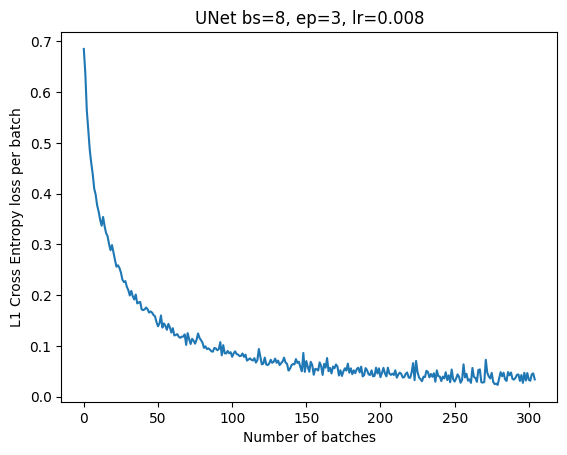

In [57]:
display(plt.plot(loss_list))
plt.title("UNet bs={}, ep={}, lr={}".format(8,3, 0.008))
plt.xlabel("Number of batches")
plt.ylabel("L1 Cross Entropy loss per batch")
plt.show()

In [58]:
torch.save(model.state_dict(), 'coronal_bite_model_weights_01.pth')#.format(4,1,0.01))

In [60]:
model = UNet() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('/kaggle/working/coronal_bite_model_weights_01.pth'))
model.eval()

UNet(
  (down1): Sequential(
    (0): Conv3x3(
      (conv1): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
  (down2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv3x3(
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128

In [61]:
batch_inputs, batch_labels = next(iter(test_loader))
print(f"Input shape: {batch_inputs.shape}, Label shape: {batch_labels.shape}")

Input shape: torch.Size([8, 1, 512, 512]), Label shape: torch.Size([8, 1, 512, 512])


In [62]:
def dice_coeff(predicted, ground_truth):
    """
    Calculates the Dice coefficient between two segmentation masks.

    Args:
      predicted: A tensor representing the predicted segmentation mask.
      ground_truth: A tensor representing the ground truth segmentation mask.

    Returns:
      A scalar value representing the Dice coefficient.
    """
    intersection = (predicted * ground_truth).sum()
    union = predicted.sum() + ground_truth.sum()
    if union == 0:
        return 1.0  # Special case for empty ground truth
    return (2 * intersection) / union


In [63]:
def jaccard_index(predicted, ground_truth):
    """
    Calculates the Jaccard index (IoU) between two segmentation masks.

    Args:
      predicted: A tensor representing the predicted segmentation mask.
      ground_truth: A tensor representing the ground truth segmentation mask.

    Returns:
      A scalar value representing the Jaccard index.
    """
    intersection = (predicted * ground_truth).sum()
    union = predicted.sum() + ground_truth.sum() - intersection
    if union == 0:
        return 1.0  # Special case for empty ground truth
    return intersection / union


In [64]:
import torch.nn.functional as F

def mean_squared_error(predicted, ground_truth):
    """
    Calculates the mean squared error between two tensors.

    Args:
      predicted: A tensor representing the predicted segmentation mask.
      ground_truth: A tensor representing the ground truth segmentation mask.

    Returns:
      A scalar value representing the mean squared error.
    """
    return F.mse_loss(predicted, ground_truth)


In [65]:
import torch

def evaluate(model, images, labels):
  """
  Evaluates the model performance on a batch of images and labels.

  Args:
      model: The U-Net model.
      images: A tensor containing the input images.
      labels: A tensor containing the ground truth segmentation masks.

  Returns:
      A dictionary containing evaluation metrics (e.g., Dice coefficient, IoU).
  """
  with torch.no_grad():  # Disable gradient calculation for evaluation
    predictions = model(images)[0]
    thresholded_target = (predictions > 0.1).float()  # Adjust the threshold as needed
    dice = dice_coeff(thresholded_target, labels[0])
    iou = jaccard_index(thresholded_target, labels[0])
    mse = mean_squared_error(thresholded_target, labels[0])
    return {'dice': dice, 'iou': iou, 'mse': mse}

# Example usage
images = batch_inputs  # Your input images
labels = batch_labels  # Your ground truth masks
model = model  # Your trained U-Net model

results = evaluate(model, images, labels)
print(f"Dice coefficient: {results['dice']:.4f}")
print(f"Jaccard index (IoU): {results['iou']:.4f}")
print(f"Mean squared error: {results['mse']:.4f}")

Dice coefficient: 0.0000
Jaccard index (IoU): 0.0000
Mean squared error: 0.0002


In [66]:
model.eval()
# Make predictions
with torch.no_grad():
    pred = model(batch_inputs)[0]
target = batch_labels[0]#.cuda()
# Threshold the values to 0 or 1
thresholded_target = (target > 0.8).float()  # Adjust the threshold as needed
# Initialize the JaccardIndex metric
jaccard = JaccardIndex(task='binary', num_classes=1)#.cuda()

# Compute IoU
iou = jaccard(pred, thresholded_target)
print("IoU (Jaccard Index):", iou.item())

IoU (Jaccard Index): 0.0


In [67]:
pred.unique()

tensor([-5.2894, -5.2751, -5.2686,  ...,  0.0379,  0.0412,  0.0452])

In [68]:
with torch.no_grad():
    pred = model(batch_inputs)
target = batch_labels

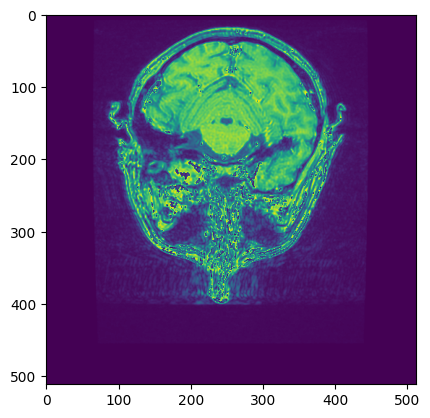

In [69]:
plt.imshow(np.array(batch_inputs[1].squeeze()))

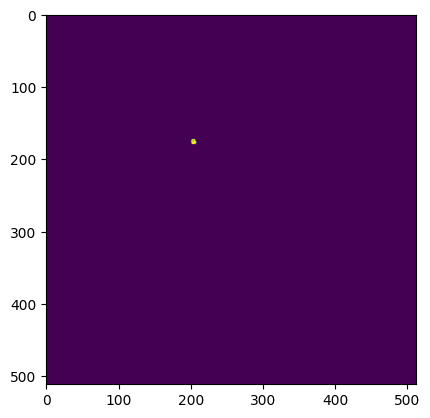

In [70]:
threshold = 0.01  # You can adjust this based on your needs
binary_predictions = (pred > threshold).float()
plt.imshow(np.array(binary_predictions[0].cpu().squeeze()*255))